In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import math
import numpy as np
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.__version__

'2.2.3'

In [3]:
%pip install pyarrow


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import sys
print(sys.executable)

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/bin/python


In [5]:
import mlflow
from mlflow import tracking

tracking.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("duration experiment")


2025/05/13 12:02:37 INFO mlflow.tracking.fluent: Experiment with name 'duration experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/529620877340114925', creation_time=1747137757986, experiment_id='529620877340114925', last_update_time=1747137757986, lifecycle_stage='active', name='duration experiment', tags={}>

In [6]:
url1="https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-01.parquet"

In [7]:
url2="https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-02.parquet"

In [8]:
df=pd.read_parquet(url1)
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee
0,2,2025-01-01 00:03:01,2025-01-01 00:17:12,N,1.0,75,235,1.0,5.93,24.70,...,0.5,6.80,0.00,NaN,1.0,34.00,1.0,1.0,0.00,0.0
1,2,2025-01-01 00:19:59,2025-01-01 00:25:52,N,1.0,166,75,1.0,1.32,8.60,...,0.5,0.00,0.00,NaN,1.0,11.10,2.0,1.0,0.00,0.0
2,2,2025-01-01 00:05:29,2025-01-01 00:07:21,N,5.0,171,73,1.0,0.41,25.55,...,0.0,0.00,0.00,NaN,1.0,26.55,2.0,2.0,0.00,0.0
3,2,2025-01-01 00:52:24,2025-01-01 01:07:52,N,1.0,74,223,1.0,4.12,21.20,...,0.5,6.13,6.94,NaN,1.0,36.77,1.0,1.0,0.00,0.0
4,2,2025-01-01 00:25:05,2025-01-01 01:01:10,N,1.0,66,158,1.0,4.71,33.80,...,0.5,7.81,0.00,NaN,1.0,46.86,1.0,1.0,2.75,0.0


In [9]:
df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge',
       'cbd_congestion_fee'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48326 entries, 0 to 48325
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               48326 non-null  int32         
 1   lpep_pickup_datetime   48326 non-null  datetime64[us]
 2   lpep_dropoff_datetime  48326 non-null  datetime64[us]
 3   store_and_fwd_flag     46490 non-null  object        
 4   RatecodeID             46490 non-null  float64       
 5   PULocationID           48326 non-null  int32         
 6   DOLocationID           48326 non-null  int32         
 7   passenger_count        46490 non-null  float64       
 8   trip_distance          48326 non-null  float64       
 9   fare_amount            48326 non-null  float64       
 10  extra                  48326 non-null  float64       
 11  mta_tax                48326 non-null  float64       
 12  tip_amount             48326 non-null  float64       
 13  t

In [11]:
def wrangle(filepath):
    df=pd.read_parquet(filepath)
    df["lpep_pickup_datetime"]=pd.to_datetime(df["lpep_pickup_datetime"])
    df["lpep_dropoff_datetime"]=pd.to_datetime(df["lpep_dropoff_datetime"])
    df["duration"]=df["lpep_dropoff_datetime"]-df["lpep_pickup_datetime"]
    df.duration=df.duration.apply(lambda td:td.total_seconds()/60)
    df=df[((df.duration>=1) & (df.duration<=60))]
    categorical=["PULocationID","DOLocationID"]
    #numerical=["trip_distance"]
    df[categorical]= df[categorical].astype(str)
    
    return df
    
        

In [12]:
df_train=wrangle(url1)
df_val=wrangle(url2)

In [13]:
df_train.tail()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee,duration
48321,2,2025-01-31 19:36:00,2025-01-31 20:05:00,None,NaN,179,132,NaN,13.99,55.61,...,11.42,0.00,NaN,1.0,68.53,NaN,NaN,NaN,NaN,29.0
48322,2,2025-01-31 20:33:00,2025-01-31 20:41:00,None,NaN,166,75,NaN,1.51,13.58,...,2.26,0.00,NaN,1.0,17.34,NaN,NaN,NaN,NaN,8.0
48323,2,2025-01-31 21:09:00,2025-01-31 21:30:00,None,NaN,41,42,NaN,2.90,30.89,...,0.00,0.00,NaN,1.0,32.39,NaN,NaN,NaN,NaN,21.0
48324,2,2025-01-31 22:22:00,2025-01-31 22:25:00,None,NaN,75,43,NaN,0.34,14.78,...,2.44,0.00,NaN,1.0,18.72,NaN,NaN,NaN,NaN,3.0
48325,2,2025-01-31 22:15:00,2025-01-31 22:22:00,None,NaN,42,194,NaN,1.37,66.67,...,10.00,6.94,NaN,1.0,85.11,NaN,NaN,NaN,NaN,7.0


In [14]:
df_train.head(5)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee,duration
0,2,2025-01-01 00:03:01,2025-01-01 00:17:12,N,1.0,75,235,1.0,5.93,24.70,...,6.80,0.00,NaN,1.0,34.00,1.0,1.0,0.00,0.0,14.183333
1,2,2025-01-01 00:19:59,2025-01-01 00:25:52,N,1.0,166,75,1.0,1.32,8.60,...,0.00,0.00,NaN,1.0,11.10,2.0,1.0,0.00,0.0,5.883333
2,2,2025-01-01 00:05:29,2025-01-01 00:07:21,N,5.0,171,73,1.0,0.41,25.55,...,0.00,0.00,NaN,1.0,26.55,2.0,2.0,0.00,0.0,1.866667
3,2,2025-01-01 00:52:24,2025-01-01 01:07:52,N,1.0,74,223,1.0,4.12,21.20,...,6.13,6.94,NaN,1.0,36.77,1.0,1.0,0.00,0.0,15.466667
4,2,2025-01-01 00:25:05,2025-01-01 01:01:10,N,1.0,66,158,1.0,4.71,33.80,...,7.81,0.00,NaN,1.0,46.86,1.0,1.0,2.75,0.0,36.083333


<Figure size 800x400 with 0 Axes>

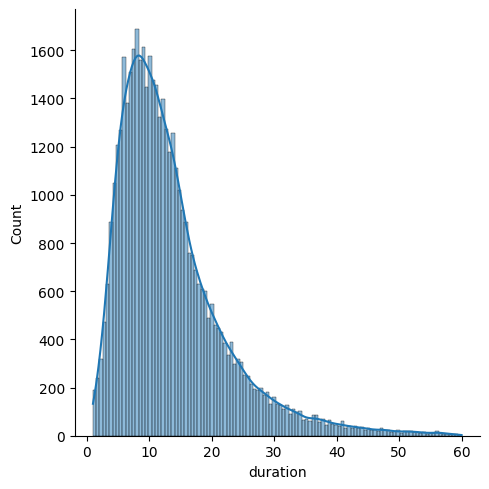

In [15]:
plt.figure(figsize=(8,4))
sns.displot(df_train.duration, kde=True);

In [16]:
df_train.duration.describe(percentiles=[0.5,0.6,0.7,0.8,0.95, 0.98, 0.99])

count    46307.000000
mean        13.493045
std          8.627705
min          1.000000
50%         11.450000
60%         13.283333
70%         15.500000
80%         18.833333
95%         30.600000
98%         38.981333
99%         44.916667
max         60.000000
Name: duration, dtype: float64

In [17]:
numerical=["trip_distance"]
categorical=["PULocationID","DOLocationID"]

train_dicts=df_train[categorical + numerical].to_dict(orient="records")
dv=DictVectorizer()
X_train=dv.fit_transform(train_dicts)


val_dicts=df_val[categorical + numerical].to_dict(orient="records")
X_val=dv.transform(val_dicts)

In [18]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 138921 stored elements and shape (46307, 449)>

In [19]:
# dv.feature_names_

In [20]:
target="duration"
y_train=df_train[target].values

y_val=df_val[target].values

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
model=LinearRegression()

In [23]:
model.fit(X_train, y_train)

LinearRegression()

In [24]:
y_pred=model.predict(X_val)

/tmp/ipykernel_7214/2601734051.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label="predictions")


/tmp/ipykernel_7214/2601734051.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label="original")


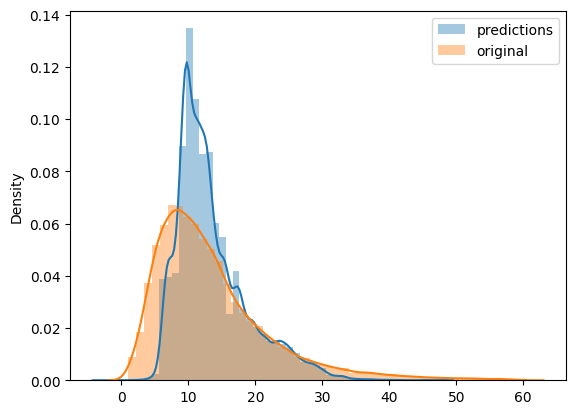

In [25]:
sns.distplot(y_pred, label="predictions")
sns.distplot(y_train, label="original")
plt.legend()

In [26]:
mean_squared_error(y_val, y_pred)

52.673907381651276

In [27]:
(np.sqrt(np.mean(np.square(y_val -  y_pred)))) #rmse

np.float64(7.257679200794926)

In [35]:
with mlflow.start_run():
    mlflow.set_tag("engineer", "ethel")
    mlflow.log_param("january_data_url","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-01.parquet")
    mlflow.log_param("february_data_url","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-02.parquet")

    alpha=0.01
    mlflow.log_param("alpha", alpha)
    model1=Lasso(alpha)
    model1.fit(X_train, y_train)
    y_pred1=model1.predict(X_val)
    rmse=(np.sqrt(np.mean(np.square(y_val -  y_pred1))))
    mlflow.log_metric("rmse", rmse)

🏃 View run dashing-auk-178 at: http://127.0.0.1:5000/#/experiments/529620877340114925/runs/8472d44a470e4f22880c93b992a5de9d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/529620877340114925


In [30]:
mean_squared_error(y_val, y_pred1)

58.5936270548088

np.float64(7.654647415446958)

In [36]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [37]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [42]:
def objective(params):
    with mlflow.start_run():
        mlflow.autolog(disable=True)
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        # Calculate RMSE directly
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [43]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:11:46] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:6.57685                           
[1]	validation-rmse:5.76151                           
[2]	validation-rmse:5.56500                           
[3]	validation-rmse:5.53523                           
[4]	validation-rmse:5.55371                           
[5]	validation-rmse:5.56134                           
[6]	validation-rmse:5.56593                           
[7]	validation-rmse:5.56592                           
[8]	validation-rmse:5.57495                           
[9]	validation-rmse:5.57601                           
[10]	validation-rmse:5.57878                          
[11]	validation-rmse:5.58141                          
[12]	validation-rmse:5.58102                          
[13]	validation-rmse:5.58289                          
[14]	validation-rmse:5.58324                          
[15]	validation-rmse:5.58634                          
[16]	validation-rmse:5.58898                          
[17]	validation-rmse:5.59523                          
[18]	valid

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:11:53] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.62815                                                     
[1]	validation-rmse:6.71461                                                     
[2]	validation-rmse:6.17664                                                     
[3]	validation-rmse:5.86741                                                     
[4]	validation-rmse:5.70400                                                     
[5]	validation-rmse:5.62288                                                     
[6]	validation-rmse:5.58596                                                     
[7]	validation-rmse:5.56777                                                     
[8]	validation-rmse:5.57262                                                     
[9]	validation-rmse:5.57725                                                     
[10]	validation-rmse:5.59019                                                    
[11]	validation-rmse:5.60590                                                    
[12]	validation-rmse:5.62026

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:12:03] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:7.19052                                                     
[2]	validation-rmse:6.61287                                                     
[3]	validation-rmse:6.21515                                                     
[4]	validation-rmse:5.94260                                                     
[5]	validation-rmse:5.75936                                                     
[6]	validation-rmse:5.64000                                                     
[7]	validation-rmse:5.55806                                                     
[8]	validation-rmse:5.51094                                                     
[9]	validation-rmse:5.47785                                                     
[10]	validation-rmse:5.45961                                                    
[11]	validation-rmse:5.44569                                                    
[12]	validation-rmse:5.44216                                                    
[13]	validation-rmse:5.43670

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:12:11] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.50950                                                    
[1]	validation-rmse:7.99906                                                    
[2]	validation-rmse:7.56634                                                    
[3]	validation-rmse:7.20332                                                    
[4]	validation-rmse:6.89276                                                    
[5]	validation-rmse:6.63685                                                    
[6]	validation-rmse:6.42314                                                    
[7]	validation-rmse:6.24801                                                    
[8]	validation-rmse:6.09907                                                    
[9]	validation-rmse:5.98308                                                    
[10]	validation-rmse:5.88460                                                   
[11]	validation-rmse:5.80762                                                   
[12]	validation-rmse:5.74547            

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:12:24] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[6]	validation-rmse:5.37296                                                    
[7]	validation-rmse:5.36101                                                    
[8]	validation-rmse:5.36765                                                    
[9]	validation-rmse:5.37556                                                    
[10]	validation-rmse:5.37197                                                   
[11]	validation-rmse:5.37683                                                   
[12]	validation-rmse:5.36974                                                   
[13]	validation-rmse:5.36728                                                   
[14]	validation-rmse:5.36698                                                   
[15]	validation-rmse:5.36015                                                   
[16]	validation-rmse:5.35937                                                   
[17]	validation-rmse:5.35268                                                   
[18]	validation-rmse:5.36108            

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:12:27] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:5.92686                                                    
[1]	validation-rmse:5.78781                                                    
[2]	validation-rmse:5.81920                                                    
[3]	validation-rmse:5.84746                                                    
[4]	validation-rmse:5.85871                                                    
[5]	validation-rmse:5.86361                                                    
[6]	validation-rmse:5.86554                                                    
[7]	validation-rmse:5.86796                                                    
[8]	validation-rmse:5.86944                                                    
[9]	validation-rmse:5.86915                                                    
[10]	validation-rmse:5.87055                                                   
[11]	validation-rmse:5.87203                                                   
[12]	validation-rmse:5.87388            

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:12:39] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:5.95295                                                    
[2]	validation-rmse:5.58697                                                    
[3]	validation-rmse:5.45786                                                    
[4]	validation-rmse:5.41323                                                    
[5]	validation-rmse:5.40057                                                    
[6]	validation-rmse:5.39237                                                    
[7]	validation-rmse:5.38349                                                    
[8]	validation-rmse:5.37715                                                    
[9]	validation-rmse:5.37601                                                    
[10]	validation-rmse:5.38410                                                   
[11]	validation-rmse:5.38489                                                   
[12]	validation-rmse:5.38502                                                   
[13]	validation-rmse:5.38455            

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:12:43] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.64182                                                    
[1]	validation-rmse:8.23037                                                    
[2]	validation-rmse:7.86556                                                    
[3]	validation-rmse:7.54430                                                    
[4]	validation-rmse:7.26400                                                    
[5]	validation-rmse:7.01789                                                    
[6]	validation-rmse:6.80376                                                    
[7]	validation-rmse:6.62048                                                    
[8]	validation-rmse:6.45785                                                    
[9]	validation-rmse:6.32338                                                    
[10]	validation-rmse:6.20721                                                   
[11]	validation-rmse:6.10237                                                   
[12]	validation-rmse:6.01706            

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:13:11] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.79987                                                    
[1]	validation-rmse:8.51656                                                    
[2]	validation-rmse:8.25359                                                    
[3]	validation-rmse:8.00966                                                    
[4]	validation-rmse:7.78393                                                    
[5]	validation-rmse:7.57472                                                    
[6]	validation-rmse:7.38248                                                    
[7]	validation-rmse:7.20812                                                    
[8]	validation-rmse:7.04707                                                    
[9]	validation-rmse:6.89900                                                    
[10]	validation-rmse:6.76579                                                   
[11]	validation-rmse:6.63976                                                   
[12]	validation-rmse:6.52737            

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:13:37] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.18168                                                    
[1]	validation-rmse:6.29318                                                    
[2]	validation-rmse:5.92090                                                    
[3]	validation-rmse:5.79311                                                    
[4]	validation-rmse:5.75631                                                    
[5]	validation-rmse:5.75276                                                    
[6]	validation-rmse:5.76240                                                    
[7]	validation-rmse:5.77307                                                    
[8]	validation-rmse:5.78511                                                    
[9]	validation-rmse:5.79329                                                    
[10]	validation-rmse:5.79706                                                   
[11]	validation-rmse:5.80129                                                   
[12]	validation-rmse:5.80454            

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:13:50] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:8.19358                                                     
[2]	validation-rmse:7.81612                                                     
[3]	validation-rmse:7.49011                                                     
[4]	validation-rmse:7.20478                                                     
[5]	validation-rmse:6.94979                                                     
[6]	validation-rmse:6.73326                                                     
[7]	validation-rmse:6.54263                                                     
[8]	validation-rmse:6.38168                                                     
[9]	validation-rmse:6.24168                                                     
[10]	validation-rmse:6.11883                                                    
[11]	validation-rmse:6.01710                                                    
[12]	validation-rmse:5.92321                                                    
[13]	validation-rmse:5.84594

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:14:00] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:5.42062                                                     
[3]	validation-rmse:5.38497                                                     
[4]	validation-rmse:5.35866                                                     
[5]	validation-rmse:5.35067                                                     
[6]	validation-rmse:5.34835                                                     
[7]	validation-rmse:5.34391                                                     
[8]	validation-rmse:5.34420                                                     
[9]	validation-rmse:5.33637                                                     
[10]	validation-rmse:5.32915                                                    
[11]	validation-rmse:5.33070                                                    
[12]	validation-rmse:5.33173                                                    
[13]	validation-rmse:5.33061                                                    
[14]	validation-rmse:5.33483

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:14:04] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.29410                                                     
[1]	validation-rmse:6.35311                                                     
[2]	validation-rmse:5.87153                                                     
[3]	validation-rmse:5.68339                                                     
[4]	validation-rmse:5.60948                                                     
[5]	validation-rmse:5.58482                                                     
[6]	validation-rmse:5.58795                                                     
[7]	validation-rmse:5.60685                                                     
[8]	validation-rmse:5.61983                                                     
[9]	validation-rmse:5.63363                                                     
[10]	validation-rmse:5.64663                                                    
[11]	validation-rmse:5.65739                                                    
[12]	validation-rmse:5.66359

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:14:18] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.25596                                                     
[1]	validation-rmse:7.59669                                                     
[2]	validation-rmse:7.09501                                                     
[3]	validation-rmse:6.70915                                                     
[4]	validation-rmse:6.43672                                                     
[5]	validation-rmse:6.23302                                                     
[6]	validation-rmse:6.09222                                                     
[7]	validation-rmse:5.98984                                                     
[8]	validation-rmse:5.92411                                                     
[9]	validation-rmse:5.87652                                                     
[10]	validation-rmse:5.84769                                                    
[11]	validation-rmse:5.82853                                                    
[12]	validation-rmse:5.82019

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:14:44] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.25591                                                     
[1]	validation-rmse:7.58139                                                     
[2]	validation-rmse:7.05647                                                     
[3]	validation-rmse:6.64743                                                     
[4]	validation-rmse:6.33069                                                     
[5]	validation-rmse:6.09253                                                     
[6]	validation-rmse:5.91489                                                     
[7]	validation-rmse:5.78188                                                     
[8]	validation-rmse:5.68401                                                     
[9]	validation-rmse:5.61304                                                     
[10]	validation-rmse:5.56296                                                    
[11]	validation-rmse:5.52574                                                    
[12]	validation-rmse:5.50055

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:14:54] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:5.61352                                                     
[3]	validation-rmse:5.45733                                                     
[4]	validation-rmse:5.39690                                                     
[5]	validation-rmse:5.37367                                                     
[6]	validation-rmse:5.35786                                                     
[7]	validation-rmse:5.34688                                                     
[8]	validation-rmse:5.33594                                                     
[9]	validation-rmse:5.33399                                                     
[10]	validation-rmse:5.33009                                                    
[11]	validation-rmse:5.33158                                                    
[12]	validation-rmse:5.33153                                                    
[13]	validation-rmse:5.32718                                                    
[14]	validation-rmse:5.33062

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:14:57] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:5.47049                                                     
[2]	validation-rmse:5.39890                                                     
[3]	validation-rmse:5.38004                                                     
[4]	validation-rmse:5.36786                                                     
[5]	validation-rmse:5.36902                                                     
[6]	validation-rmse:5.36226                                                     
[7]	validation-rmse:5.35196                                                     
[8]	validation-rmse:5.35245                                                     
[9]	validation-rmse:5.35643                                                     
[10]	validation-rmse:5.35613                                                    
[11]	validation-rmse:5.35584                                                    
[12]	validation-rmse:5.36617                                                    
[13]	validation-rmse:5.36271

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:15:00] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.46293                                                     
[1]	validation-rmse:7.92302                                                     
[2]	validation-rmse:7.46878                                                     
[3]	validation-rmse:7.09494                                                     
[4]	validation-rmse:6.78205                                                     
[5]	validation-rmse:6.52856                                                     
[6]	validation-rmse:6.31691                                                     
[7]	validation-rmse:6.14882                                                     
[8]	validation-rmse:6.01668                                                     
[9]	validation-rmse:5.90991                                                     
[10]	validation-rmse:5.82605                                                    
[11]	validation-rmse:5.76429                                                    
[12]	validation-rmse:5.71124

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:15:18] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[5]	validation-rmse:5.36073                                                     
[6]	validation-rmse:5.35009                                                     
[7]	validation-rmse:5.34671                                                     
[8]	validation-rmse:5.33935                                                     
[9]	validation-rmse:5.33229                                                     
[10]	validation-rmse:5.32445                                                    
[11]	validation-rmse:5.32379                                                    
[12]	validation-rmse:5.32263                                                    
[13]	validation-rmse:5.32207                                                    
[14]	validation-rmse:5.31450                                                    
[15]	validation-rmse:5.30853                                                    
[16]	validation-rmse:5.30600                                                    
[17]	validation-rmse:5.30291

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:15:21] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:5.68569                                                     
[1]	validation-rmse:5.44749                                                     
[2]	validation-rmse:5.45429                                                     
[3]	validation-rmse:5.45327                                                     
[4]	validation-rmse:5.44451                                                     
[5]	validation-rmse:5.44719                                                     
[6]	validation-rmse:5.44443                                                     
[7]	validation-rmse:5.44155                                                     
[8]	validation-rmse:5.44541                                                     
[9]	validation-rmse:5.45329                                                     
[10]	validation-rmse:5.45137                                                    
[11]	validation-rmse:5.45910                                                    
[12]	validation-rmse:5.46239

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:15:27] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[13]	validation-rmse:5.45747                                                    
[14]	validation-rmse:5.45283                                                    
[15]	validation-rmse:5.44708                                                    
[16]	validation-rmse:5.44045                                                    
[17]	validation-rmse:5.43547                                                    
[18]	validation-rmse:5.42365                                                    
[19]	validation-rmse:5.41950                                                    
[20]	validation-rmse:5.41618                                                    
[21]	validation-rmse:5.41655                                                    
[22]	validation-rmse:5.41273                                                    
[23]	validation-rmse:5.40901                                                    
[24]	validation-rmse:5.39878                                                    
[25]	validation-rmse:5.39550

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:15:31] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[16]	validation-rmse:5.49009
[17]	validation-rmse:5.48621                                                    
[18]	validation-rmse:5.47940                                                    
[19]	validation-rmse:5.47528                                                    
[20]	validation-rmse:5.46789                                                    
[21]	validation-rmse:5.46115                                                    
[22]	validation-rmse:5.45813                                                    
[23]	validation-rmse:5.44821                                                    
[24]	validation-rmse:5.44494                                                    
[25]	validation-rmse:5.44321                                                    
[26]	validation-rmse:5.44094                                                    
[27]	validation-rmse:5.43540                                                    
[28]	validation-rmse:5.43184                                                    

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:15:39] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[14]	validation-rmse:5.45856                                                    
[15]	validation-rmse:5.45980                                                    
[16]	validation-rmse:5.45446                                                    
[17]	validation-rmse:5.45325                                                    
[18]	validation-rmse:5.44322                                                    
[19]	validation-rmse:5.44324                                                    
[20]	validation-rmse:5.44141                                                    
[21]	validation-rmse:5.43210                                                    
[22]	validation-rmse:5.43136                                                    
[23]	validation-rmse:5.43302                                                    
[24]	validation-rmse:5.42045                                                    
[25]	validation-rmse:5.41404                                                    
[26]	validation-rmse:5.41088

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:15:42] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[7]	validation-rmse:5.58979                                                     
[8]	validation-rmse:5.55884                                                     
[9]	validation-rmse:5.53102                                                     
[10]	validation-rmse:5.51075                                                    
[11]	validation-rmse:5.49355                                                    
[12]	validation-rmse:5.48528                                                    
[13]	validation-rmse:5.47352                                                    
[14]	validation-rmse:5.46597                                                    
[15]	validation-rmse:5.45846                                                    
[16]	validation-rmse:5.44747                                                    
[17]	validation-rmse:5.44172                                                    
[18]	validation-rmse:5.43630                                                    
[19]	validation-rmse:5.43162

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:15:52] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[6]	validation-rmse:5.51036                                                     
[7]	validation-rmse:5.46082                                                     
[8]	validation-rmse:5.42444                                                     
[9]	validation-rmse:5.40134                                                     
[10]	validation-rmse:5.38434                                                    
[11]	validation-rmse:5.37312                                                    
[12]	validation-rmse:5.36137                                                    
[13]	validation-rmse:5.35557                                                    
[14]	validation-rmse:5.35100                                                    
[15]	validation-rmse:5.34291                                                    
[16]	validation-rmse:5.33894                                                    
[17]	validation-rmse:5.33558                                                    
[18]	validation-rmse:5.33181

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:15:58] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[6]	validation-rmse:5.72416                                                     
[7]	validation-rmse:5.62409                                                     
[8]	validation-rmse:5.55359                                                     
[9]	validation-rmse:5.50521                                                     
[10]	validation-rmse:5.46760                                                    
[11]	validation-rmse:5.44280                                                    
[12]	validation-rmse:5.42233                                                    
[13]	validation-rmse:5.40527                                                    
[14]	validation-rmse:5.39159                                                    
[15]	validation-rmse:5.38087                                                    
[16]	validation-rmse:5.37325                                                    
[17]	validation-rmse:5.36666                                                    
[18]	validation-rmse:5.35783

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:16:03] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[4]	validation-rmse:6.04084                                                     
[5]	validation-rmse:5.84934                                                     
[6]	validation-rmse:5.70915                                                     
[7]	validation-rmse:5.60752                                                     
[8]	validation-rmse:5.53830                                                     
[9]	validation-rmse:5.48824                                                     
[10]	validation-rmse:5.45148                                                    
[11]	validation-rmse:5.42633                                                    
[12]	validation-rmse:5.40779                                                    
[13]	validation-rmse:5.39004                                                    
[14]	validation-rmse:5.37716                                                    
[15]	validation-rmse:5.36844                                                    
[16]	validation-rmse:5.36304

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:16:09] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[5]	validation-rmse:6.00666                                                     
[6]	validation-rmse:5.84292                                                     
[7]	validation-rmse:5.72451                                                     
[8]	validation-rmse:5.63892                                                     
[9]	validation-rmse:5.57422                                                     
[10]	validation-rmse:5.52628                                                    
[11]	validation-rmse:5.48835                                                    
[12]	validation-rmse:5.46141                                                    
[13]	validation-rmse:5.43966                                                    
[14]	validation-rmse:5.42244                                                    
[15]	validation-rmse:5.40869                                                    
[16]	validation-rmse:5.39752                                                    
[17]	validation-rmse:5.38705

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:16:15] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:7.15569                                                     
[3]	validation-rmse:6.75244                                                     
[4]	validation-rmse:6.43536                                                     
[5]	validation-rmse:6.19206                                                     
[6]	validation-rmse:6.00177                                                     
[7]	validation-rmse:5.85631                                                     
[8]	validation-rmse:5.74412                                                     
[9]	validation-rmse:5.66005                                                     
[10]	validation-rmse:5.59446                                                    
[11]	validation-rmse:5.54236                                                    
[12]	validation-rmse:5.50489                                                    
[13]	validation-rmse:5.47577                                                    
[14]	validation-rmse:5.45376

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:16:25] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[5]	validation-rmse:5.49347                                                     
[6]	validation-rmse:5.44068                                                     
[7]	validation-rmse:5.40965                                                     
[8]	validation-rmse:5.38972                                                     
[9]	validation-rmse:5.37522                                                     
[10]	validation-rmse:5.36133                                                    
[11]	validation-rmse:5.35123                                                    
[12]	validation-rmse:5.34452                                                    
[13]	validation-rmse:5.33892                                                    
[14]	validation-rmse:5.33364                                                    
[15]	validation-rmse:5.33080                                                    
[16]	validation-rmse:5.33022                                                    
[17]	validation-rmse:5.32446

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:16:29] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:8.49579                                                     
[2]	validation-rmse:8.22592                                                     
[3]	validation-rmse:7.97518                                                     
[4]	validation-rmse:7.74442                                                     
[5]	validation-rmse:7.53183                                                     
[6]	validation-rmse:7.33687                                                     
[7]	validation-rmse:7.15561                                                     
[8]	validation-rmse:6.99059                                                     
[9]	validation-rmse:6.84043                                                     
[10]	validation-rmse:6.70108                                                    
[11]	validation-rmse:6.57658                                                    
[12]	validation-rmse:6.46084                                                    
[13]	validation-rmse:6.35686

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:16:44] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[3]	validation-rmse:6.03749                                                     
[4]	validation-rmse:5.80532                                                     
[5]	validation-rmse:5.66006                                                     
[6]	validation-rmse:5.56920                                                     
[7]	validation-rmse:5.50637                                                     
[8]	validation-rmse:5.46961                                                     
[9]	validation-rmse:5.44145                                                     
[10]	validation-rmse:5.42405                                                    
[11]	validation-rmse:5.41128                                                    
[12]	validation-rmse:5.40186                                                    
[13]	validation-rmse:5.39153                                                    
[14]	validation-rmse:5.37870                                                    
[15]	validation-rmse:5.37209

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:16:50] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.41479                                                     
[1]	validation-rmse:7.83559                                                     
[2]	validation-rmse:7.35998                                                     
[3]	validation-rmse:6.96790                                                     
[4]	validation-rmse:6.65579                                                     
[5]	validation-rmse:6.39721                                                     
[6]	validation-rmse:6.19169                                                     
[7]	validation-rmse:6.02231                                                     
[8]	validation-rmse:5.88769                                                     
[9]	validation-rmse:5.78632                                                     
[10]	validation-rmse:5.70677                                                    
[11]	validation-rmse:5.63897                                                    
[12]	validation-rmse:5.58840

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:16:57] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[9]	validation-rmse:5.58778                                                     
[10]	validation-rmse:5.53691                                                    
[11]	validation-rmse:5.50613                                                    
[12]	validation-rmse:5.48388                                                    
[13]	validation-rmse:5.46285                                                    
[14]	validation-rmse:5.44728                                                    
[15]	validation-rmse:5.43208                                                    
[16]	validation-rmse:5.42301                                                    
[17]	validation-rmse:5.41400                                                    
[18]	validation-rmse:5.40610                                                    
[19]	validation-rmse:5.40224                                                    
[20]	validation-rmse:5.39554                                                    
[21]	validation-rmse:5.38891

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:17:02] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[3]	validation-rmse:7.69881                                                     
[4]	validation-rmse:7.42923                                                     
[5]	validation-rmse:7.19264                                                     
[6]	validation-rmse:6.97859                                                     
[7]	validation-rmse:6.78919                                                     
[8]	validation-rmse:6.61894                                                     
[9]	validation-rmse:6.46905                                                     
[10]	validation-rmse:6.33685                                                    
[11]	validation-rmse:6.21807                                                    
[12]	validation-rmse:6.11513                                                    
[13]	validation-rmse:6.02239                                                    
[14]	validation-rmse:5.94300                                                    
[15]	validation-rmse:5.87312

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:17:13] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:6.59658                                                     
[2]	validation-rmse:6.06422                                                     
[3]	validation-rmse:5.76831                                                     
[4]	validation-rmse:5.60003                                                     
[5]	validation-rmse:5.50705                                                     
[6]	validation-rmse:5.45238                                                     
[7]	validation-rmse:5.42136                                                     
[8]	validation-rmse:5.39962                                                     
[9]	validation-rmse:5.38743                                                     
[10]	validation-rmse:5.37495                                                    
[11]	validation-rmse:5.37075                                                    
[12]	validation-rmse:5.35961                                                    
[13]	validation-rmse:5.35140

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:17:20] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:6.45620                                                     
[3]	validation-rmse:6.07245                                                     
[4]	validation-rmse:5.82374                                                     
[5]	validation-rmse:5.66253                                                     
[6]	validation-rmse:5.55941                                                     
[7]	validation-rmse:5.49358                                                     
[8]	validation-rmse:5.44737                                                     
[9]	validation-rmse:5.41705                                                     
[10]	validation-rmse:5.39609                                                    
[11]	validation-rmse:5.38303                                                    
[12]	validation-rmse:5.37277                                                    
[13]	validation-rmse:5.36171                                                    
[14]	validation-rmse:5.35409

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:17:27] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.56694                                                     
[1]	validation-rmse:8.10318                                                     
[2]	validation-rmse:7.69513                                                     
[3]	validation-rmse:7.35071                                                     
[4]	validation-rmse:7.04862                                                     
[5]	validation-rmse:6.79640                                                     
[6]	validation-rmse:6.57953                                                     
[7]	validation-rmse:6.40076                                                     
[8]	validation-rmse:6.24251                                                     
[9]	validation-rmse:6.11063                                                     
[10]	validation-rmse:6.00627                                                    
[11]	validation-rmse:5.91875                                                    
[12]	validation-rmse:5.84762

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:17:39] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:7.46113                                                     
[2]	validation-rmse:6.91680                                                     
[3]	validation-rmse:6.50194                                                     
[4]	validation-rmse:6.19311                                                     
[5]	validation-rmse:5.96370                                                     
[6]	validation-rmse:5.79697                                                     
[7]	validation-rmse:5.67500                                                     
[8]	validation-rmse:5.58896                                                     
[9]	validation-rmse:5.52572                                                     
[10]	validation-rmse:5.47973                                                    
[11]	validation-rmse:5.44971                                                    
[12]	validation-rmse:5.42599                                                    
[13]	validation-rmse:5.40834

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:17:45] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[11]	validation-rmse:6.51435                                                    
[12]	validation-rmse:6.40774                                                    
[13]	validation-rmse:6.31207                                                    
[14]	validation-rmse:6.22541                                                    
[15]	validation-rmse:6.14736                                                    
[16]	validation-rmse:6.07793                                                    
[17]	validation-rmse:6.01566                                                    
[18]	validation-rmse:5.96005                                                    
[19]	validation-rmse:5.90965                                                    
[20]	validation-rmse:5.86392                                                    
[21]	validation-rmse:5.82311                                                    
[22]	validation-rmse:5.78707                                                    
[23]	validation-rmse:5.75385

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:18:04] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:8.33982                                                     
[2]	validation-rmse:8.01164                                                     
[3]	validation-rmse:7.71667                                                     
[4]	validation-rmse:7.45070                                                     
[5]	validation-rmse:7.21192                                                     
[6]	validation-rmse:6.99771                                                     
[7]	validation-rmse:6.80923                                                     
[8]	validation-rmse:6.63810                                                     
[9]	validation-rmse:6.48829                                                     
[10]	validation-rmse:6.35093                                                    
[11]	validation-rmse:6.23164                                                    
[12]	validation-rmse:6.12549                                                    
[13]	validation-rmse:6.03092

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:18:13] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[4]	validation-rmse:5.42844                                                     
[5]	validation-rmse:5.39712                                                     
[6]	validation-rmse:5.37602                                                     
[7]	validation-rmse:5.36380                                                     
[8]	validation-rmse:5.35413                                                     
[9]	validation-rmse:5.34842                                                     
[10]	validation-rmse:5.34332                                                    
[11]	validation-rmse:5.33976                                                    
[12]	validation-rmse:5.33322                                                    
[13]	validation-rmse:5.33080                                                    
[14]	validation-rmse:5.32588                                                    
[15]	validation-rmse:5.32400                                                    
[16]	validation-rmse:5.32047

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:18:19] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[5]	validation-rmse:7.59578                                                     
[6]	validation-rmse:7.41077                                                     
[7]	validation-rmse:7.23815                                                     
[8]	validation-rmse:7.08082                                                     
[9]	validation-rmse:6.93854                                                     
[10]	validation-rmse:6.80811                                                    
[11]	validation-rmse:6.68836                                                    
[12]	validation-rmse:6.58048                                                    
[13]	validation-rmse:6.48187                                                    
[14]	validation-rmse:6.39302                                                    
[15]	validation-rmse:6.31112                                                    
[16]	validation-rmse:6.23786                                                    
[17]	validation-rmse:6.16996

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:18:34] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.13459                                                     
[1]	validation-rmse:6.17983                                                     
[2]	validation-rmse:5.73306                                                     
[3]	validation-rmse:5.55101                                                     
[4]	validation-rmse:5.47878                                                     
[5]	validation-rmse:5.45613                                                     
[6]	validation-rmse:5.44346                                                     
[7]	validation-rmse:5.43900                                                     
[8]	validation-rmse:5.43618                                                     
[9]	validation-rmse:5.43660                                                     
[10]	validation-rmse:5.43621                                                    
[11]	validation-rmse:5.43744                                                    
[12]	validation-rmse:5.43777

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:18:39] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.43099                                                     
[1]	validation-rmse:7.86501                                                     
[2]	validation-rmse:7.39368                                                     
[3]	validation-rmse:7.00777                                                     
[4]	validation-rmse:6.68649                                                     
[5]	validation-rmse:6.42643                                                     
[6]	validation-rmse:6.21485                                                     
[7]	validation-rmse:6.04692                                                     
[8]	validation-rmse:5.91040                                                     
[9]	validation-rmse:5.80387                                                     
[10]	validation-rmse:5.71838                                                    
[11]	validation-rmse:5.65223                                                    
[12]	validation-rmse:5.59958

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:18:50] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:8.07661                                                     
[3]	validation-rmse:7.79413                                                     
[4]	validation-rmse:7.53861                                                     
[5]	validation-rmse:7.30798                                                     
[6]	validation-rmse:7.09984                                                     
[7]	validation-rmse:6.91290                                                     
[8]	validation-rmse:6.74511                                                     
[9]	validation-rmse:6.59440                                                     
[10]	validation-rmse:6.45907                                                    
[11]	validation-rmse:6.33774                                                    
[12]	validation-rmse:6.22942                                                    
[13]	validation-rmse:6.13398                                                    
[14]	validation-rmse:6.04787

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:19:09] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:7.27249                                                     
[3]	validation-rmse:6.87782                                                     
[4]	validation-rmse:6.56228                                                     
[5]	validation-rmse:6.31032                                                     
[6]	validation-rmse:6.11235                                                     
[7]	validation-rmse:5.95745                                                     
[8]	validation-rmse:5.83605                                                     
[9]	validation-rmse:5.73924                                                     
[10]	validation-rmse:5.66423                                                    
[11]	validation-rmse:5.60430                                                    
[12]	validation-rmse:5.55761                                                    
[13]	validation-rmse:5.52023                                                    
[14]	validation-rmse:5.49195

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:19:23] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:7.69892                                                     
[3]	validation-rmse:7.34773                                                     
[4]	validation-rmse:7.04504                                                     
[5]	validation-rmse:6.78543                                                     
[6]	validation-rmse:6.56258                                                     
[7]	validation-rmse:6.37362                                                     
[8]	validation-rmse:6.21168                                                     
[9]	validation-rmse:6.07508                                                     
[10]	validation-rmse:5.95996                                                    
[11]	validation-rmse:5.86295                                                    
[12]	validation-rmse:5.78087                                                    
[13]	validation-rmse:5.71231                                                    
[14]	validation-rmse:5.65332

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:19:31] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:7.02613                                                     
[2]	validation-rmse:6.44081                                                     
[3]	validation-rmse:6.05485                                                     
[4]	validation-rmse:5.79647                                                     
[5]	validation-rmse:5.63211                                                     
[6]	validation-rmse:5.52870                                                     
[7]	validation-rmse:5.46175                                                     
[8]	validation-rmse:5.42564                                                     
[9]	validation-rmse:5.39837                                                     
[10]	validation-rmse:5.37594                                                    
[11]	validation-rmse:5.36187                                                    
[12]	validation-rmse:5.35216                                                    
[13]	validation-rmse:5.34872

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:19:35] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[4]	validation-rmse:5.42663                                                     
[5]	validation-rmse:5.39673                                                     
[6]	validation-rmse:5.37951                                                     
[7]	validation-rmse:5.35767                                                     
[8]	validation-rmse:5.34765                                                     
[9]	validation-rmse:5.34459                                                     
[10]	validation-rmse:5.33943                                                    
[11]	validation-rmse:5.33199                                                    
[12]	validation-rmse:5.32501                                                    
[13]	validation-rmse:5.32270                                                    
[14]	validation-rmse:5.31442                                                    
[15]	validation-rmse:5.31065                                                    
[16]	validation-rmse:5.30482

In [44]:
params={ 
"reg_alpha":0.015143662957798473,
"seed" :42,
"learning_rate":0.2635721416413519,
"objective": "reg:linear",
"min_child_weight" :11.354716447890874,
"max_depth" :6,
"reg_lambda" :0.006716153330161491

}

mlflow.xgboost.autolog()
booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )

2025/05/13 14:00:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '43b40243c8b3450d9e19db24b487377a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation-rmse:7.75728
[1]	validation-rmse:6.89496


/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [14:00:35] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[2]	validation-rmse:6.35428
[3]	validation-rmse:6.03694
[4]	validation-rmse:5.83999
[5]	validation-rmse:5.72057
[6]	validation-rmse:5.63619
[7]	validation-rmse:5.58979
[8]	validation-rmse:5.55884
[9]	validation-rmse:5.53102
[10]	validation-rmse:5.51075
[11]	validation-rmse:5.49355
[12]	validation-rmse:5.48528
[13]	validation-rmse:5.47352
[14]	validation-rmse:5.46597
[15]	validation-rmse:5.45846
[16]	validation-rmse:5.44747
[17]	validation-rmse:5.44172
[18]	validation-rmse:5.43630
[19]	validation-rmse:5.43162
[20]	validation-rmse:5.42706
[21]	validation-rmse:5.42413
[22]	validation-rmse:5.42200
[23]	validation-rmse:5.41746
[24]	validation-rmse:5.41362
[25]	validation-rmse:5.41235
[26]	validation-rmse:5.40921
[27]	validation-rmse:5.40714
[28]	validation-rmse:5.40417
[29]	validation-rmse:5.40131
[30]	validation-rmse:5.39692
[31]	validation-rmse:5.39410
[32]	validation-rmse:5.39185
[33]	validation-rmse:5.38707
[34]	validation-rmse:5.38363
[35]	validation-rmse:5.38162
[36]	validation-rmse:5

2025/05/13 14:00:45 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/05/13 14:00:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [14:00:45] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/05/13 14:00:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run serious-hog-325 at: http://127.0.0.1:5000/#/experiments/529620877340114925/runs/43b40243c8b3450d9e19db24b487377a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/529620877340114925


In [32]:
# sns.distplot(y_pred1, label="predictions")
# sns.distplot(y_train, label="original")
# plt.legend()

58.5936270548088

In [33]:
import pickle

In [34]:
with open ('models/lin_reg.bin' , 'wb') as f_out:
    pickle.dump((dv, model), f_out)